imagenet labels https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
subset of imagenet
https://www.kaggle.com/ifigotin/imagenetmini-1000

In [1]:
!mkdir ~/.kaggle
!echo '{"username":"","key":""}' > ~/.kaggle/kaggle.json
!kaggle datasets download -d ifigotin/imagenetmini-1000

100% 3.91G/3.92G [00:50<00:00, 75.6MB/s]
100% 3.92G/3.92G [00:51<00:00, 82.5MB/s]


In [2]:
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

--2020-06-08 12:26:23--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsidx_to_labels.txt’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0.01s   

2020-06-08 12:26:24 (2.26 MB/s) - ‘imagenet1000_clsidx_to_labels.txt’ saved [30564/30564]



In [3]:
!unzip imagenetmini-1000.zip

Streaming output truncated to the last 5000 lines.
  inflating: imagenet-mini/train/n07875152/n07875152_2763.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_3015.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_3378.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_3497.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_3745.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_4157.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_461.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_4704.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_4789.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_4848.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_4940.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_546.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_5607.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_5711.JPEG  
  inflating: imagenet-mini/train/n0787515

In [4]:
!pip install colour

In [0]:
def seed_torch(seed=31415):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [0]:
from __future__ import print_function, division

import os
import time
import copy
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision.models import alexnet, vgg19_bn
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torch.autograd import Variable

import cv2


from colour import Color

#from cifar10module.cifar10_models import vgg19_bn

#from pycocotools.coco import COCO

#plt.ion()   # interactive mode

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    # img = img / torch.from_numpy(np.array([0.229, 0.224, 0.225])) + torch.from_numpy(np.array([0.485, 0.456, 0.406]))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [0]:
def accuracy(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [0]:
def softmax(tensor):
    expsum = torch.sum(torch.exp(tensor), len(tensor.size()) - 1)
    
    return torch.exp(tensor) / expsum

In [0]:
def predict(model, images: torch.Tensor) -> torch.Tensor:
    model.eval()
    if len(images.size()) == 3:  # single image
        preds = model.forward(images.unsqueeze(0)) # very костыль но что поделать
    elif len(images.size()) == 4:  # multiple images
        preds = model.forward(images)
    
    return torch.stack([softmax(p) for p in preds])

In [0]:
def compute_ocluded_copies(image: torch.tensor, patch_size: (int, int), color = None) -> [torch.tensor]:
    """
    принимает нормализованный тензор изображения и размер патча
    
    возвращает несколько изображений на каждом из которых закрыта часть  
    
    !А еще предполагаем что прилетают квадратные изображения!
    """
    color_ins = (0, 0, 0)
    if color:
        color_ins = color 
    
    ans = []
    
    _, width, height = image.size()
    for h in range(0, height, patch_size[0]):
        for w in range(0, width, patch_size[1]):
            temp = image.numpy()
            temp = np.transpose(temp, (1, 2, 0))
            temp = cv2.rectangle(cv2.UMat(temp).get(), (w, h), (w + patch_size[0], h + patch_size[1]), 
                                 color_ins, -1)
            temp = np.transpose(temp , (2, 0, 1))
            temp = torch.from_numpy(temp)
            ans.append(temp)
        
    return  torch.stack(ans)

In [0]:
def draw_heatmap(originial_image: torch.Tensor, 
                 normal_pred:     float, 
                 ocluded_preds:   [float], 
                 patch_size:      (int, int),
                 alpha:           int = 1) -> None:
    """
    Draws a heatmap of "importance" of all patches
    """
    

    # computing differences
    diffs = np.abs(np.array(ocluded_preds) - normal_pred)
    mindiff, maxdiff = diffs.min(), diffs.max()

    # colors_count colors -> colors_count corresponding tresholds to each color
    colors_count = 10
    colors = list(Color("blue").range_to(Color("red"), colors_count))
    tresholds = np.arange(mindiff, maxdiff, (maxdiff - mindiff) / colors_count)
    
    _, width, height = originial_image.size()
    
    counter = 0
    
    original_umat = originial_image.numpy()
    original_umat = np.transpose(original_umat, (1, 2, 0))
    original_umat = cv2.UMat(original_umat).get()
    
    overlay = original_umat.copy()

    for h in range(0, height, patch_size[0]):
        for w in range(0, width, patch_size[1]):
            # print(np.argmin(np.abs(tresholds - diffs[counter])))
            # print(tresholds)
            # print(diffs[counter])
            color = colors[np.argmin(np.abs(tresholds - diffs[counter]))].rgb
            counter += 1 
            
            
            cv2.rectangle(overlay, (w, h), (w + patch_size[0], h + patch_size[1]), 
                          color, -1)  # original image with opaque colored patch
            
            
    
    final = cv2.addWeighted(overlay, alpha , original_umat, 1 - alpha, 0)  # adding colored box to original
    final = np.transpose(final , (2, 0, 1))
    final = torch.from_numpy(final)        
    imshow(final)

In [13]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

trainset = torchvision.datasets.CIFAR10(root='./data/cifar', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data/cifar', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar/cifar-10-python.tar.gz to ./data/cifar
Files already downloaded and verified


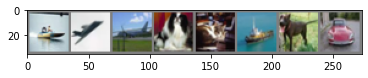


 ship plane plane   dog   cat  ship   dog   car


In [14]:
# get some random training images
dataiter = iter(trainloader)
train_images, train_labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(train_images))
# print labels
print(' '.join('%5s' % classes[train_labels[j]] for j in range(8)))

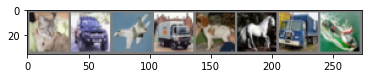

GroundTruth:    cat   car plane truck   dog horse truck  ship


In [15]:
dataiter = iter(testloader)
dataiter.next()
test_images, test_labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(test_images))
print('GroundTruth: ', ' '.join('%5s' % classes[test_labels[j]] for j in range(8)))

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [21]:
seed_torch()
vgg19 = vgg19_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth


In [22]:
outputs = vgg19(test_images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(8)))

IndexError: ignored

In [0]:
accuracy(vgg19, testloader)

KeyboardInterrupt: 

Вот с этого момента начинаю делать хитмапу

In [0]:
print(*enumerate(classes))

(0, 'plane') (1, 'car') (2, 'bird') (3, 'cat') (4, 'deer') (5, 'dog') (6, 'frog') (7, 'horse') (8, 'ship') (9, 'truck')


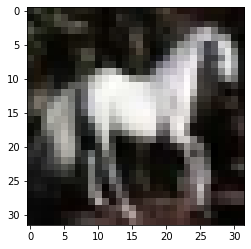

('horse', 0.35184189677238464)

In [0]:
# Путскаем в модель изображение без изменений
seed_torch()

image_number = 5
test_image = test_images[image_number]

pred = predict(vgg19, test_image)
imshow(test_image)
classes[torch.argmax(pred)], torch.max(pred).item()

In [0]:
patch_size = (2, 2)
ocluded_images = compute_ocluded_copies(test_image, patch_size)

### Надо заметить, что закрашивать стоит черным цветом, потому что при белом цвете алгоритм предсказывает абсолютно рандомно...... Почему(???)

0


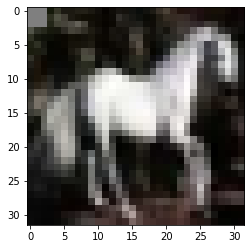

Pred class: horse - 0.40
True class: horse - 0.40
------------------
1


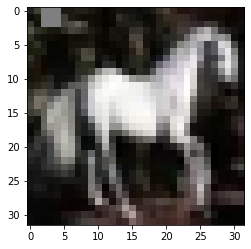

Pred class: horse - 0.36
True class: horse - 0.36
------------------
2


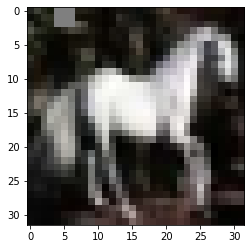

Pred class: horse - 0.46
True class: horse - 0.46
------------------
3


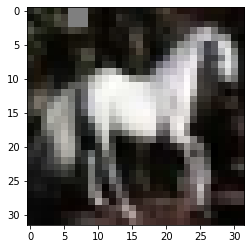

Pred class: horse - 0.51
True class: horse - 0.51
------------------
4


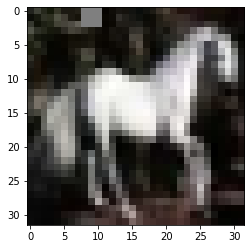

Pred class: horse - 0.36
True class: horse - 0.36
------------------
5


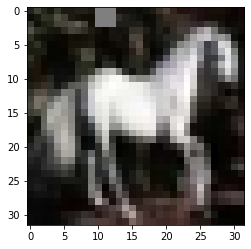

Pred class: horse - 0.49
True class: horse - 0.49
------------------
6


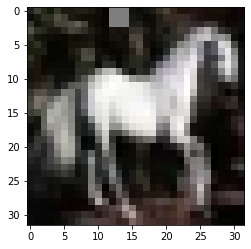

Pred class: horse - 0.46
True class: horse - 0.46
------------------
7


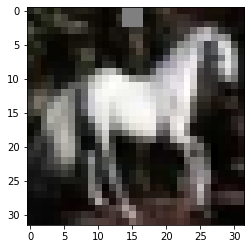

Pred class: horse - 0.49
True class: horse - 0.49
------------------
8


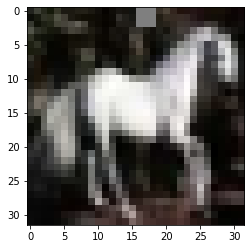

Pred class: horse - 0.55
True class: horse - 0.55
------------------
9


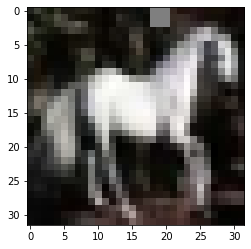

Pred class: horse - 0.56
True class: horse - 0.56
------------------


In [0]:
seed_torch()
ocluded_preds = predict(vgg19, ocluded_images)
for i, pred in enumerate(ocluded_preds[:10]):
    print(i)

    imshow(ocluded_images[i])
    pred_class_label = classes[torch.argmax(pred)]
    pred_class_prob = torch.max(pred)
    
    print(f"Pred class: {pred_class_label} - {pred_class_prob:.2f}")
    print(f"True class: horse - {pred[7]:.2f}")  # we know its a horse 
    print("------------------")

### Теперь можно вычесть из изначального значения вероятности - вероятности,  полученные после прогона частично закрытых изображений

In [0]:
ocluded_preds_horse = [x[7].item() for x in ocluded_preds]
ocluded_preds_horse[:10]

[0.4011778235435486,
 0.3637775480747223,
 0.4618929624557495,
 0.5141099095344543,
 0.36477580666542053,
 0.4885390102863312,
 0.45704886317253113,
 0.49020758271217346,
 0.5476167798042297,
 0.5646193027496338]

Возник вопросик каким образом закрашивать изображение (??????????????????)

То есть как выстроить шкалу изменений в предсказании...?

Давай думать тогда  что еще делать 

diff = normal_score - occluded_score

- diff > 0  - плохо, уверенность уменьшилась
- diff < 0  - хорошо, уверенность увеличилась


так посмотрим просто на крайние случаи

- До закрытия патча было 1 - после закрытия стало 0 - максимально плохо   diff = 1
- До закрытия патча было 0 - после закрытия стало 1 - максимально хорошо diff = 0

Сответственно можем выстроить шкалу от 0 до 1, где 
- 0 - синий цвет (патч не нужен) 
- 1 - красный цвет (патч очень важен)

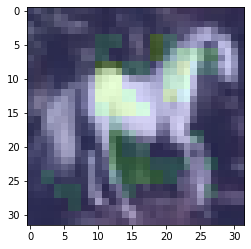

In [0]:
normal_pred = torch.max(predict(vgg19, test_image)).item()
draw_heatmap(test_image, normal_pred, ocluded_preds_horse, patch_size, 0.3)

---

---

---

In [0]:
coco_api = COCO("./data/coco/annotations/instances_train2014.json")
categories_coco = coco_api.loadCats(coco_api.getCatIds())
categories_coco = [cat['name'] for cat in categories_coco]
len(categories_coco) 

loading annotations into memory...
Done (t=10.01s)
creating index...
index created!


80

In [0]:
transform_coco = transforms.Compose(
    [
     transforms.CenterCrop(300),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

In [0]:
trainset_coco = torchvision.datasets.CocoDetection(root='./data/coco/train2014',
                                              annFile='./data/coco/annotations/instances_train2014.json', 
                                              transform=transform_coco)

trainloader_coco = torch.utils.data.DataLoader(trainset_coco, batch_size=4,
                                          shuffle=True, num_workers=0)

testset_coco = torchvision.datasets.CocoDetection(root='./data/coco/val2014', 
                                              annFile='./data/coco/annotations/instances_val2014.json', 
                                              transform=transform_coco)

testloader_coco = torch.utils.data.DataLoader(testset_coco, batch_size=4,
                                           shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=7.96s)
creating index...
index created!
loading annotations into memory...
Done (t=3.80s)
creating index...
index created!


In [0]:
dataiter_test_coco = iter(testloader_coco)
test_images_coco, test_labels_coco = dataiter_test_coco.next()

In [0]:
test_labels_coco

[{'segmentation': [[tensor([189.5200, 281.2600,  52.2500, 398.0100], dtype=torch.float64),
    tensor([243.5500, 443.3400,   3.9600, 233.4000], dtype=torch.float64),
    tensor([181.4500, 271.2100,  50.5600, 397.2000], dtype=torch.float64),
    tensor([220.1600, 391.6800,  28.3900, 357.2600], dtype=torch.float64),
    tensor([183.0600, 243.9500,  62.3600, 365.0300], dtype=torch.float64),
    tensor([207.2600, 340.0200,  79.8000, 348.4100], dtype=torch.float64),
    tensor([187.1000, 246.8200,  70.7900, 340.9000], dtype=torch.float64),
    tensor([197.5800, 282.6200,  98.3400, 323.4800], dtype=torch.float64),
    tensor([157.2600, 265.4700,  79.2100, 334.4700], dtype=torch.float64),
    tensor([147.5800, 220.9100, 105.9200, 313.0300], dtype=torch.float64),
    tensor([150.8100, 291.3000,  23.6000, 326.4200], dtype=torch.float64),
    tensor([130.6500, 186.4800, 110.9800, 322.6800], dtype=torch.float64),
    tensor([163.7100, 322.8700,   5.0600, 307.9200], dtype=torch.float64),
    tenso

In [0]:
vgg11 = torchvision.models.vgg11(pretrained=True, num_classes=80)
preds = predict(vgg11, test_images_coco)
preds

tensor([[4.8630e-06, 2.5767e-04, 5.6189e-05,  ..., 1.1913e-06, 2.9610e-04,
         5.9602e-03],
        [3.5685e-05, 5.0359e-07, 1.4246e-05,  ..., 3.7221e-05, 5.1869e-05,
         1.1697e-03],
        [4.9171e-05, 1.3194e-04, 1.1224e-04,  ..., 8.3959e-05, 4.3057e-05,
         2.1598e-02],
        [1.0035e-06, 1.2969e-05, 4.6399e-06,  ..., 2.1987e-06, 2.5332e-05,
         6.7459e-04]], grad_fn=<StackBackward>)

In [0]:
preds.size()

torch.Size([4, 1000])

---

---

---

In [0]:
seed_torch(2)
batch_size = 8

transform_imagenet = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(240),
        transforms.ToTensor(),
        transforms.Normalize(mean=torch.from_numpy(np.array([0.485, 0.456, 0.406])),
                             std=torch.from_numpy(np.array([0.229, 0.224, 0.225])))
     ])

trainset_imagenet = torchvision.datasets.ImageFolder(root='./imagenet-mini/train/',
                                              transform=transform_imagenet)

trainloader_imagenet = torch.utils.data.DataLoader(trainset_imagenet, batch_size=batch_size,
                                                   shuffle=True, num_workers=0)

testset_imagenet = torchvision.datasets.ImageFolder(root='./imagenet-mini/val/', 
                                              transform=transform_imagenet)

testloader_imagenet = torch.utils.data.DataLoader(testset_imagenet, batch_size=batch_size,
                                                 shuffle=True, num_workers=0)

In [0]:
vgg11  = vgg11_bn(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg11  = vgg11.to(device)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/checkpoints/vgg11_bn-6002323d.pth


In [0]:
number_to_class = {}
with open("imagenet1000_clsidx_to_labels.txt", "r") as f:
    for line in f.readlines():
        line = line.replace("{", "").replace("}", "")
        class_number, class_name = line.split(':')
        number_to_class[int(class_number)] = class_name.split(',')[0].replace("'", '').replace(" ", "").replace('"', "")

In [0]:
dataiter_imagenet = iter(testloader_imagenet)
test_images, test_labels = dataiter_imagenet.next()
test_images, test_labels = dataiter_imagenet.next()
test_images, test_labels = dataiter_imagenet.next()
test_images, test_labels = dataiter_imagenet.next()
test_images, test_labels = dataiter_imagenet.next()
test_images, test_labels = dataiter_imagenet.next()
test_images, test_labels = dataiter_imagenet.next()
test_images, test_labels = dataiter_imagenet.next()
test_images, test_labels = dataiter_imagenet.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


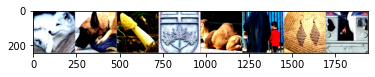

GroundTruth:  Arcticfox malinois stinkhorn shield Arabiancamel abaya chainmail parkingmeter


In [0]:
seed_torch(2)
imshow(torchvision.utils.make_grid(test_images))
print('GroundTruth: ', ' '.join('%5s' % number_to_class[test_labels[j].item()] for j in range(batch_size)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


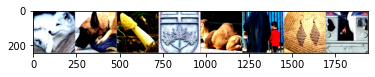

Predicted:  Arcticfox malinois stinkhorn shield Arabiancamel abaya chainmail parkingmeter


In [0]:
seed_torch(2)
preds = predict(vgg11, test_images)
pred_class_label = [number_to_class[int(torch.argmax(p))] for p in preds]

imshow(torchvision.utils.make_grid(test_images))
print('Predicted: ', ' '.join('%5s' % pred_class_label[j] for j in range(batch_size)))

In [0]:
seed_torch(2)
patch_size = (24, 24)
image_number = 0
class_number = 279  # 145 потому что класс king penguin

normal_pred = preds[image_number][class_number].item()

In [0]:
seed_torch(2)
ocluded = compute_ocluded_copies(test_images[image_number], patch_size)

In [0]:
seed_torch(2)
ocluded_preds = [x[class_number].item() for x in predict(vgg11, ocluded)]  

In [0]:
draw_heatmap(test_images[image_number], normal_pred, ocluded_preds, patch_size, 0.7)
print("Arctic fox")

In [0]:
torch.max(predict(vgg11, ocluded[0]))

tensor(0.9724, grad_fn=<MaxBackward1>)

In [0]:
ocluded_preds, normal_pred

([0.0015599316684529185,
  0.0020239297300577164,
  0.002516693202778697,
  0.0015692332526668906,
  0.0026206395123153925,
  0.00354216992855072,
  0.0022526890970766544,
  0.0027671693824231625,
  0.0038401621859520674,
  0.0029950414318591356,
  0.002989186206832528,
  0.0009668614948168397,
  0.0015202106442302465,
  0.0005416223430074751,
  0.0023280878085643053,
  0.004592201206833124,
  0.008231348358094692,
  0.011248958297073841,
  0.0022498376201838255,
  0.004629919305443764,
  0.002516338601708412,
  0.00035280646989122033,
  0.0023141130805015564,
  0.0014080113032832742,
  0.0018990569515153766,
  0.0015801249537616968,
  0.002475702203810215,
  0.001302166492678225,
  0.0012730826856568456,
  0.0002408842701697722,
  0.0005984854069538414,
  0.0018595702713355422,
  0.0005378190544433892,
  0.0025204033590853214,
  0.0012069408548995852,
  0.0008408480789512396,
  0.0021390768233686686,
  0.0007557643693871796,
  0.0005628886865451932,
  0.003997902385890484,
  0.0047106

Вот здесь стало заметно, что если перекрывать черными квадратиками, то все предсказания могут сбиться поэтому надо что-то поумнее https://www.cs.virginia.edu/~connelly/class/2014/comp_photo/proj2/poisson.pdf

In [0]:
del ocluded
del vgg11
torch.cuda.empty_cache()

In [0]:
seed_torch(2)
torch.max(predict(vgg11, test_images[1].repeat(4, 1, 1, 1)))

tensor(0.6695, grad_fn=<MaxBackward1>)